In [1]:
import numpy as np
import imutils
from matplotlib import pyplot as plt
import cv2
import itertools

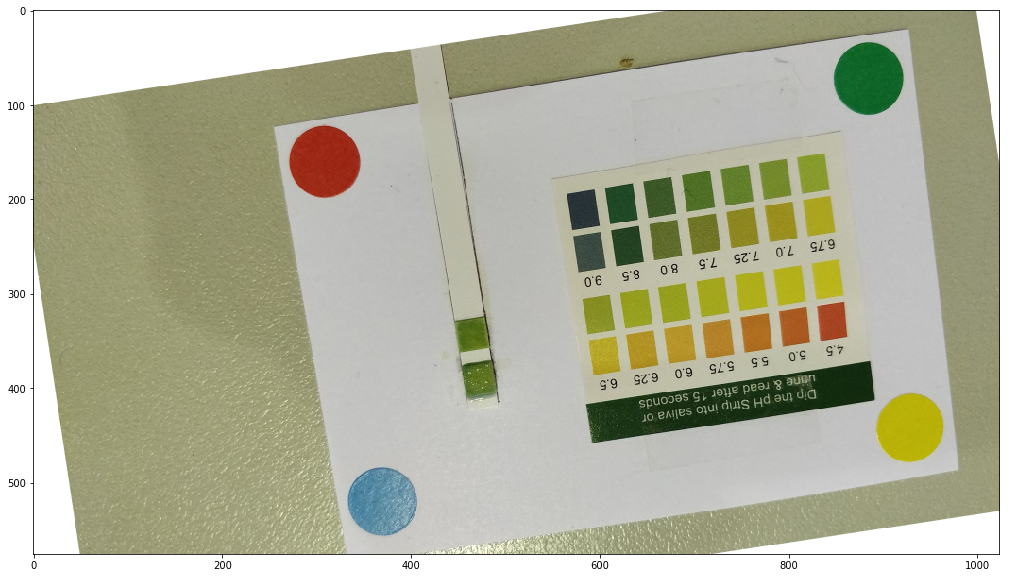

In [20]:
image = imutils.resize(cv2.imread('Data/rotated.jpg'), width=1024)
plt.figure(figsize=(18,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

param1 = 30
param2 = 90
for i in range(0, 100, 1):
    par1 = param1+(i / 2 + i % 2)
    par2 = param2-(i / 2 + ((i + 1) % 2))
    circles = cv2.HoughCircles(gray_image,cv2.HOUGH_GRADIENT,1,20,
                            param1=par1,param2=par2,minRadius=20,maxRadius=50)
    # print(circles.shape if circles is not None else "None")
    if (circles is not None) and circles.shape[1] == 4:
        print(circles.shape)
        break
if not ((circles is not None) and circles.shape[1] == 4):
    print("Failed")

(1, 4, 3)


In [4]:
circled = image.copy()
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(circled,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(circled,(i[0],i[1]),1,(0,0,255),2)

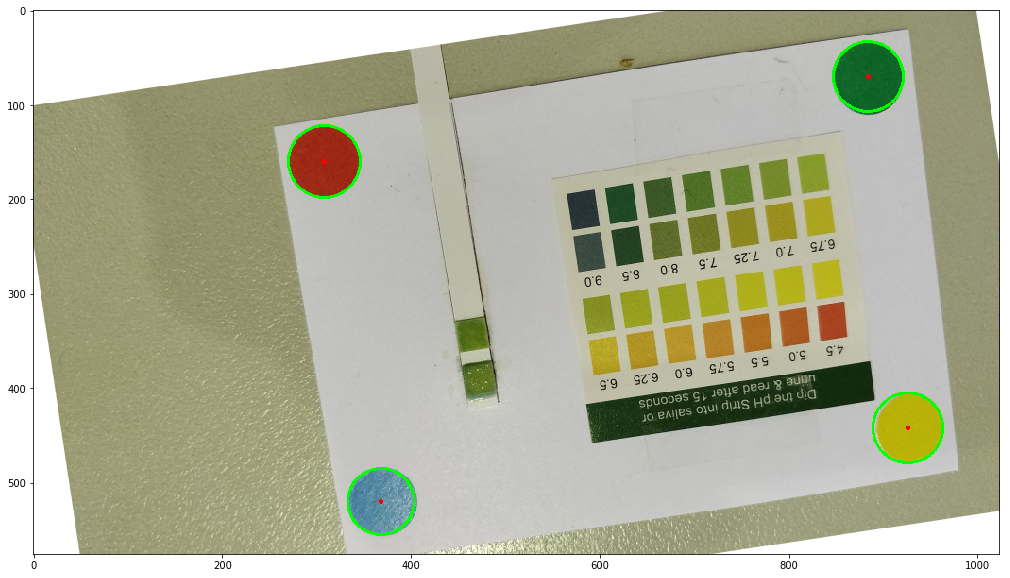

In [5]:
plt.figure(figsize=(18,10))
plt.imshow(cv2.cvtColor(circled, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
def color_dist(col_temp, col_match):
    return np.sum(np.abs(col_temp - col_match))       

def find_perm(array_match):
    yellow = [255,255,0]
    blue = [65,105,225]
    green = [50,205,50]
    red = [255,0,0]
    array_template = np.array([[yellow, blue, red, green]])

    perm_list = list(itertools.permutations([0,1,2,3]))
    distances_list = []
    for perm in perm_list:
        total_dist = 0
        for i in range(4):
            total_dist += color_dist(array_match[0][perm[i]], array_template[0][i])
        distances_list.append(total_dist)
    min_index = np.argmin(np.array(distances_list))
    perm = perm_list[min_index]
    return perm

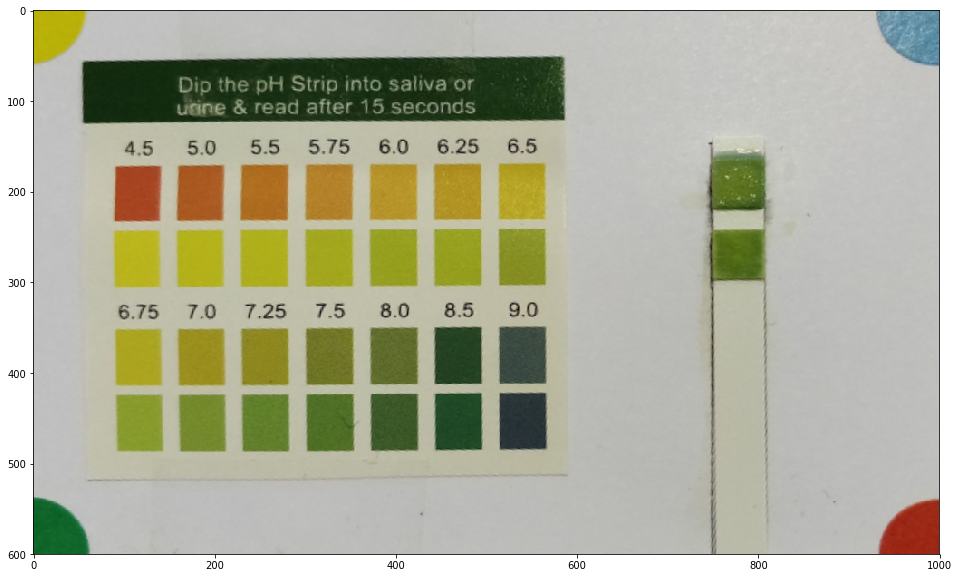

In [15]:
array2 = [[list(reversed(image[i[1], i[0]])) for i in circles[0,:]]]
array_match = np.array(array2)
perm = find_perm(array_match)

def get_pos(coord):
    return (coord[0], coord[1])

def create_map(circles):
    coords = [get_pos(circles[0,:][perm[i]]) for i in range(4)]
    return np.array(coords)

coords = create_map(circles)

positions = np.array([(0, 0), (1000, 0), (1000, 600), (0, 600)])
h, status = cv2.findHomography(coords, positions)

cropped = cv2.warpPerspective(image, h, (1000, 600))
plt.figure(figsize=(18,10))
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

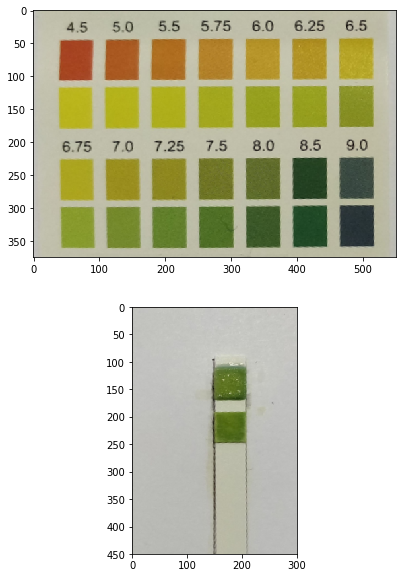

In [55]:
left_cropped = cropped[125:500, 50:600]
right_cropped = cropped[50:500, 600:900]

plt.figure(figsize=(18,10))
plt.subplot(2,1,1)
plt.imshow(cv2.cvtColor(left_cropped, cv2.COLOR_BGR2RGB))
plt.subplot(2,1,2)
plt.imshow(cv2.cvtColor(right_cropped, cv2.COLOR_BGR2RGB))

In [48]:
def get_colors(img, X_pos, Y_pos):
    colors = []
    for i, y in enumerate(Y_pos):
        colors.append([])
        for x in X_pos:
            # take mean for +- 2 pixels
            mean_col = list(reversed(np.uint8(np.round(np.mean(img[y-2:y+2, x-2:x+2], axis=(0,1))))))
            colors[i].append(mean_col)
    return colors

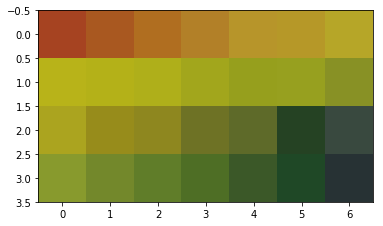

In [136]:
colors = get_colors(cropped, range(100, 600, 75), [200, 270, 380, 460])
plt.imshow(colors)

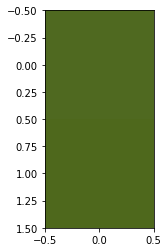

In [140]:
matches = get_colors(cropped, [800], [200, 270])
plt.imshow(matches)

375
6


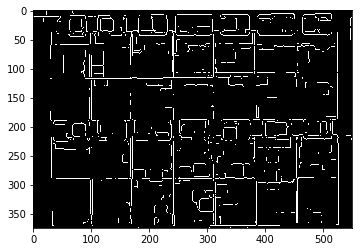

In [111]:
kernel = np.ones((5,5),np.uint8)
img = cv2.erode(left_cropped,kernel,iterations = 5)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,100,200,apertureSize = 5)
print(len(edges))
lines = cv2.HoughLines(edges,1,np.pi/180,200)
if lines is not None and len(lines) > 0:
    print(len(lines))
    for rho,theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

plt.imshow(cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB))